In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import infercnvpy as cnv
import matplotlib

import sys
sys.path.append("../..")
import insitucnv as icv

/home/sergio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load functions

In [ ]:
import numpy as np

def compute_cnv_metrics(adata):
    """
    Compute CNV performance metrics based on ground truth and CNV values.
    
    Parameters:
    - adata: AnnData object containing CNV ground truth in `adata.layers['CNV_GT']`
             and CNV values in `adata.layers['gene_values_cnv']`
    
    Returns:
    - Dictionary with F1 scores for overall CNV detection, CNV gain, and CNV loss.
    """
    ground_truth = adata.layers['CNV_GT']
    cnv_values = adata.layers["gene_values_cnv"]

    # Extract CNV scores based on ground truth
    cnv_score_in_gains = [x for x in cnv_values[ground_truth == 1] if str(x) != 'nan']
    cnv_score_in_losses = [x for x in cnv_values[ground_truth == -1] if str(x) != 'nan']
    cnv_score_in_neutrals = [x for x in cnv_values[ground_truth == 0] if str(x) != 'nan']
    cnv_score_in_cnv = [x for x in cnv_values[ground_truth != 0] if str(x) != 'nan']

    # Compute true and false classifications
    true_gains = len([e for e in cnv_score_in_gains if e > 0]) / len(cnv_score_in_gains)
    true_losses = len([e for e in cnv_score_in_losses if e < 0]) / len(cnv_score_in_losses)
    true_neutrals = np.sum(np.abs(cnv_score_in_neutrals) == 0) / len(cnv_score_in_neutrals)
    true_cnv = np.sum(np.abs(cnv_score_in_cnv) != 0) / len(cnv_score_in_cnv)

    false_neutrals = 1 - true_neutrals
    false_cnv = 1 - true_cnv

    # Compute performance metrics
    results_all = icv.tl.compute_performance_metrics(true_cnv, false_neutrals, true_neutrals, false_cnv)
    results_gain = icv.tl.compute_performance_metrics(true_gains, false_neutrals, true_neutrals, 1 - true_gains)
    results_loss = icv.tl.compute_performance_metrics(true_losses, false_neutrals, true_neutrals, 1 - true_losses)

    return {
        "All": results_all['F1 Score'],
        "Gain": results_gain['F1 Score'],
        "Loss": results_loss['F1 Score']
    }

def compute_cnv_auc(adata):
    """
    Compute ROC AUC and PR AUC for CNV gains and losses.

    Parameters:
    - adata: AnnData object containing CNV ground truth in `adata.layers['CNV_GT']`
             and CNV inferred scores in `adata.layers['gene_values_cnv']`

    Returns:
    - Dictionary with ROC AUC and PR AUC scores for CNV gains and losses.
    """
    ground_truth = adata.layers['CNV_GT']
    cnv_values = adata.layers["gene_values_cnv"]

    # Flatten arrays for processing
    simulated = ground_truth.flatten()  
    inferred_scores = cnv_values.flatten()  

    # Remove NaN values
    filter_nan = np.array([str(x) != 'nan' for x in inferred_scores])
    simulated = simulated[filter_nan]
    inferred_scores = inferred_scores[filter_nan]

    # Compute AUC for gains (1) and losses (-1)
    roc_auc_gains, pr_auc_gains = icv.tl.compute_auc(simulated, inferred_scores, 1)
    roc_auc_losses, pr_auc_losses = icv.tl.compute_auc(simulated, inferred_scores, -1)

    return {"ROC AUC (Gains)": roc_auc_gains,"PR AUC (Gains)": pr_auc_gains,
        "ROC AUC (Losses)": roc_auc_losses,"PR AUC (Losses)": pr_auc_losses}


# Load datasets

In [5]:
path_simulation='/media/external/test/augusta/insituCNV/data/simulated_CNV_data/technical_limiting_conditions'

In [129]:
files

['CNV_simulated_subsampled_counts_70.h5ad',
 'CNV_simulated_subsampled_counts_50.h5ad',
 'CNV_simulated_subsampled_counts_20.h5ad',
 'CNV_simulated_subsampled_counts_10.h5ad',
 'CNV_simulated_subsampled_counts_5.h5ad',
 'CNV_simulated_subsampled_counts_1.h5ad',
 'CNV_simulated_subsampled_genes_20000_CNVinf.h5ad',
 'CNV_simulated_subsampled_genes_15000_CNVinf.h5ad',
 'CNV_simulated_subsampled_genes_10000_CNVinf.h5ad',
 'CNV_simulated_subsampled_genes_5000_CNVinf.h5ad',
 'CNV_simulated_subsampled_genes_1000_CNVinf.h5ad',
 'CNV_simulated_subsampled_genes_500_CNVinf.h5ad',
 'CNV_simulated_subsampled_counts_70_CNVinf.h5ad',
 'CNV_simulated_subsampled_counts_50_CNVinf.h5ad',
 'CNV_simulated_subsampled_counts_20_CNVinf.h5ad',
 'CNV_simulated_subsampled_counts_10_CNVinf.h5ad',
 'CNV_simulated_subsampled_counts_5_CNVinf.h5ad',
 'CNV_simulated_subsampled_counts_1_CNVinf.h5ad',
 'CNV_simulated_subsampled_genes_20000.h5ad',
 'CNV_simulated_subsampled_genes_15000.h5ad',
 'CNV_simulated_subsampled_g

In [48]:
files=os.listdir(path_simulation)
processed_datasets=[f  for f in files if '_CNVinf' in f]
processed_datasets_counts=[f  for f in processed_datasets if 'counts' in f]

## Quantify on different counts

We aim to compare the output of CNV prediction on simulated datasets, first varying the number of counts captured on each cell

In [100]:
file='CNV_simulated_subsampled_counts_1_CNVinf.h5ad'

In [101]:
adata=sc.read(os.path.join(path_simulation,file))

In [103]:
adata

AnnData object with n_obs × n_vars = 1268 × 25691
    obs: 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'model_id', 'sample_id', 'Phase', 'level_1', 'level_2', 'level_3', 'CountUMIs', 'CountGenes', 'X.Mitochondrial', 'NoveltyScore', 'nCount_SCT', 'nFeature_SCT', 'orig.ident', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cnv_leiden', 'simulated_subclone', 'cnv_leiden_res0.7', 'cnv_score'
    var: 'gene_symbols', 'feature_is_filtered',

370.47476

In [110]:
results=pd.DataFrame(columns=['type_of_sampling','number','n_genes','mean_countsxcell','nmi','ari','F1score_all','F1score_gain',
                      'F1score_loss','ROC_gains','PR_gains','ROC_loss','PR_loss'])
i=0
for file in processed_datasets_counts:
    print(file)
    type_of_subsampling=file.split('_')[3]
    number=file.split('_')[4]
    adata=sc.read(os.path.join(path_simulation,file))
    # clustering similarity metrics
    comp_key=[a for a in adata.obs.columns if 'cnv_leiden_res' in a]
    ari = icv.tl.compute_ari(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    nmi = icv.tl.compute_nmi(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    # CNV predictability metrics
    F1score_dict=compute_cnv_metrics(adata)
    ROC_PR_dict=compute_cnv_auc(adata)
    
    ## formatting them as CNVs
    results.loc[i,'type_of_sampling']=type_of_subsampling
    results.loc[i,'number']=number
    results.loc[i,'n_genes']=adata.var.shape[0]
    results.loc[i,'mean_countsxcell']=np.mean(np.sum(adata.layers['CNV_simulated_raw'].todense(),axis=1)) # confirm with augusta
    results.loc[i,'ari']=ari
    results.loc[i,'nmi']=nmi
    results.loc[i,'F1score_all']=F1score_dict['All']
    results.loc[i,'F1score_gain']=F1score_dict['Gain']
    results.loc[i,'F1score_loss']=F1score_dict['Loss']
    results.loc[i,'AUC_gains']=ROC_PR_dict['ROC AUC (Gains)']
    results.loc[i,'PR_gains']=ROC_PR_dict['PR AUC (Gains)']
    results.loc[i,'AUC_loss']=ROC_PR_dict['ROC AUC (Losses)']
    results.loc[i,'PR_loss']=ROC_PR_dict['PR AUC (Losses)']
    i=i+1

CNV_simulated_subsampled_counts_70_CNVinf.h5ad
CNV_simulated_subsampled_counts_50_CNVinf.h5ad
CNV_simulated_subsampled_counts_20_CNVinf.h5ad
CNV_simulated_subsampled_counts_10_CNVinf.h5ad
CNV_simulated_subsampled_counts_5_CNVinf.h5ad
CNV_simulated_subsampled_counts_1_CNVinf.h5ad
CNV_simulated_subsampled_counts_100_CNVinf.h5ad


## Save results and plot them:

In [117]:
saving_path='/home/sergio/Jnotebooks/inferCNV/InSituCNV/Figure2/04_Compare_results_using_metrics'
results.to_csv(os.path.join(saving_path,'metrics_cnv_inference_across_counts.csv'))

In [111]:
results['number']=results['number'].astype(float)

In [112]:
results=results.sort_values(by='number')

In [118]:
results

,type_of_sampling,number,n_genes,mean_countsxcell,nmi,ari,F1score_all,F1score_gain,F1score_loss,ROC_gains,PR_gains,ROC_loss,PR_loss
5,counts,1.0,25691,370.474762,0.14273,0.138379,0.570136,0.745353,0,0.79772,0.141274,0.516716,0.001859
4,counts,5.0,25691,1852.374634,0.486211,0.536215,0.674683,0.86216,0.030624,0.892132,0.501135,0.518027,0.001855
3,counts,10.0,25691,3704.75,0.68555,0.634274,0.71301,0.877506,0.182385,0.90676,0.628777,0.556952,0.003039
2,counts,20.0,25691,7409.5,0.795845,0.84301,0.7857,0.894188,0.485729,0.922307,0.690137,0.665035,0.020321
1,counts,50.0,25691,18523.75,0.919954,0.950559,0.833743,0.899521,0.674899,0.928056,0.716165,0.76347,0.120775
0,counts,70.0,25691,25933.25,0.888086,0.919409,0.838957,0.899267,0.699427,0.928151,0.715456,0.780286,0.148895
6,counts,100.0,25691,37047.5,0.913175,0.93402,0.837737,0.890061,0.719302,0.920729,0.669057,0.792467,0.139218


Text(0.5, 0, 'Subsampled counts')

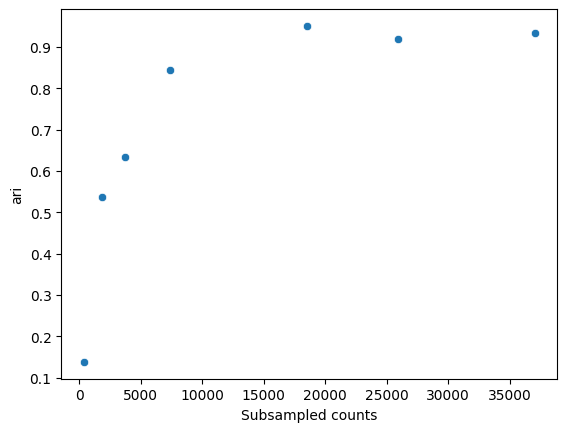

In [120]:
sns.scatterplot(data=results,x='mean_countsxcell',y='ari')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

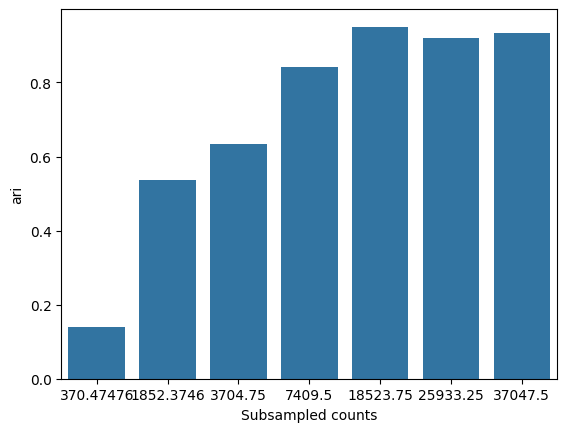

In [119]:
sns.barplot(data=results,x='number',y='ari')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

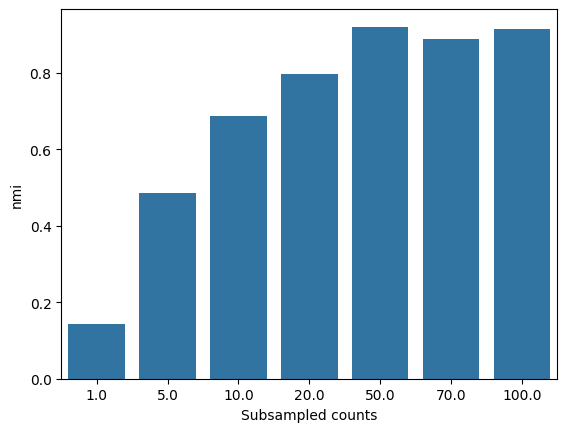

In [114]:
sns.barplot(data=results,x='number',y='nmi')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

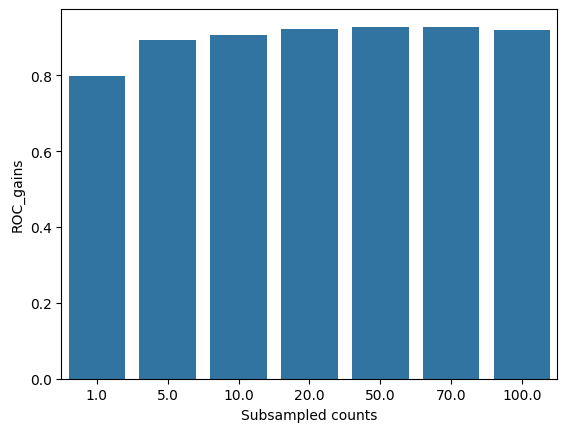

In [115]:
sns.barplot(data=results,x='number',y='AUC_gains')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

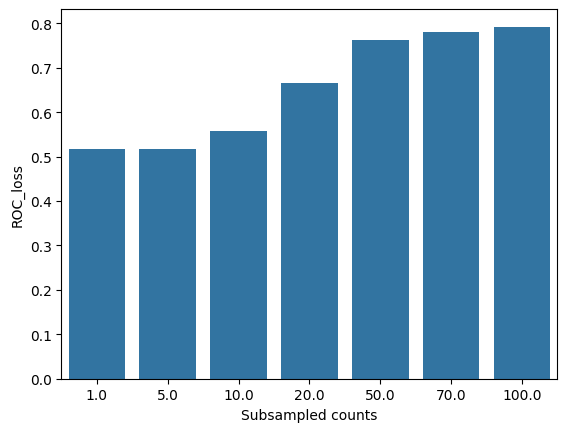

In [116]:
sns.barplot(data=results,x='number',y='AUC_loss')
plt.xlabel('Subsampled counts')

# Quantify on different number of genes

In [121]:
files=os.listdir(path_simulation)
processed_datasets=[f  for f in files if '_CNVinf' in f]
processed_datasets_genes=[f  for f in processed_datasets if 'genes' in f]

In [123]:
results=pd.DataFrame(columns=['type_of_sampling','number','n_genes','mean_countsxcell','nmi','ari','F1score_all','F1score_gain',
                      'F1score_loss','ROC_gains','PR_gains','ROC_loss','PR_loss'])
i=0
for file in processed_datasets_genes:
    print(file)
    type_of_subsampling=file.split('_')[3]
    number=file.split('_')[4]
    adata=sc.read(os.path.join(path_simulation,file))
    # clustering similarity metrics
    comp_key=[a for a in adata.obs.columns if 'cnv_leiden_res' in a]
    ari = icv.tl.compute_ari(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    nmi = icv.tl.compute_nmi(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    # CNV predictability metrics
    F1score_dict=compute_cnv_metrics(adata)
    ROC_PR_dict=compute_cnv_auc(adata)
    
    ## formatting them as CNVs
    results.loc[i,'type_of_subsampling']=type_of_subsampling
    results.loc[i,'number']=number
    results.loc[i,'n_genes']=adata.var.shape[0]
    results.loc[i,'mean_countsxcell']=np.mean(np.sum(adata.raw.X.todense(),axis=1))
    results.loc[i,'ari']=ari
    results.loc[i,'nmi']=nmi
    results.loc[i,'F1score_all']=F1score_dict['All']
    results.loc[i,'F1score_gain']=F1score_dict['Gain']
    results.loc[i,'F1score_loss']=F1score_dict['Loss']
    results.loc[i,'ROC_gains']=ROC_PR_dict['ROC AUC (Gains)']
    results.loc[i,'PR_gains']=ROC_PR_dict['PR AUC (Gains)']
    results.loc[i,'ROC_loss']=ROC_PR_dict['ROC AUC (Losses)']
    results.loc[i,'PR_loss']=ROC_PR_dict['PR AUC (Losses)']
    i=i+1

CNV_simulated_subsampled_genes_20000_CNVinf.h5ad
CNV_simulated_subsampled_genes_15000_CNVinf.h5ad
CNV_simulated_subsampled_genes_10000_CNVinf.h5ad
CNV_simulated_subsampled_genes_5000_CNVinf.h5ad
CNV_simulated_subsampled_genes_1000_CNVinf.h5ad
CNV_simulated_subsampled_genes_500_CNVinf.h5ad


ZeroDivisionError: division by zero

In [127]:
adata.layers['CNV_GT']

(1268, 500)

In [128]:
results

,type_of_sampling,number,n_genes,mean_countsxcell,nmi,ari,F1score_all,F1score_gain,F1score_loss,ROC_gains,PR_gains,ROC_loss,PR_loss,type_of_subsampling
0,NaN,20000,20000,36649.726562,0.86585,0.899906,0.837228,0.880649,0.734394,0.912566,0.61487,0.802043,0.110029,genes
1,NaN,15000,15000,36649.726562,0.761346,0.811618,0.803605,0.859413,0.647895,0.894559,0.543801,0.749478,0.027004,genes
2,NaN,10000,10000,36649.726562,0.657495,0.68681,0.798659,0.833538,0.686374,0.874251,0.332565,0.770927,0.033713,genes
3,NaN,5000,5000,36649.726562,0.293116,0.308157,0.614047,0.67975,0.348538,0.768242,0.077869,0.598268,0.003173,genes
4,NaN,1000,1000,36649.726562,0.005908,0.002708,0.295252,0.24001,0.268637,0.567799,0.002809,0.558521,0.003068,genes
